In [38]:
from model import ContrastivePretrain

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

DEVICE = 1
model = ContrastivePretrain.load_from_checkpoint('model/2022-01-18_10-25-50_NCEPretrain_frozen_lstm.ckpt').cuda(DEVICE)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [39]:
!nvidia-smi

Tue Feb  8 16:09:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:37:00.0 Off |                  Off |
| 33%   32C    P8    11W / 260W |   4610MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:86:00.0 Off |                  Off |
| 33%   

In [40]:
import torch

import pandas as pd

from transformers import AutoTokenizer
from data import build_dataset
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('roberta-large')

test = pd.read_csv('gutenberg_test.csv')
test_data = build_dataset(test, tokenizer, steps=100*100, batch_size=100, num_workers=2, prefetch_factor=2, max_len=512)

In [41]:
# Top-k accuracy
from sklearn.metrics import top_k_accuracy_score, accuracy_score
import torch.nn.functional as F
import numpy as np

acc, topk = [], []
results = {}
N = [10, 20, 40, 60, 80, 100] 


for n in N:
    test_data = build_dataset(test, tokenizer, steps=n*100, batch_size=n, num_workers=2, prefetch_factor=2, max_len=512)
    log_name = f'N={n}'
    for a_ids, a_att, b_ids, b_att in tqdm(iter(test_data)):
        with torch.no_grad():
            a_emb = model(a_ids.cuda(DEVICE), a_att.cuda(DEVICE))
            b_emb = model(b_ids.cuda(DEVICE), b_att.cuda(DEVICE))

            logits = a_emb @ b_emb.T
            preds_a = F.softmax(logits, dim=-1)
            preds_b = F.softmax(logits.T, dim=-1)

            labels = torch.arange(0, len(logits)).numpy()

            a_topk = top_k_accuracy_score(labels, preds_a.cpu().numpy(), k=5)
            b_topk = top_k_accuracy_score(labels, preds_b.cpu().numpy(), k=5)

            a_acc = accuracy_score(labels, preds_a.argmax(-1).cpu().numpy())
            b_acc = accuracy_score(labels, preds_b.argmax(-1).cpu().numpy())

            acc.append((a_acc+b_acc)/2)
            topk.append((a_topk+b_topk)/2)
            
    results[log_name] = {'Top-1 Accuracy average': np.mean(acc), 'Top-1 Accuracy std': np.std(acc),
                          'Top-5 Accuracy average': np.mean(topk), 'Top-5 Accuracy std': np.std(topk),
                         }
    print(n)
    print(results[log_name])
final_frame = pd.DataFrame(results)
final_frame
#embeddings = trainer.predict(model, test_data)

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

10
{'Top-1 Accuracy average': 0.8785, 'Top-1 Accuracy std': 0.13043293295789987, 'Top-5 Accuracy average': 0.9850000000000001, 'Top-5 Accuracy std': 0.03840572873934303}



100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

20
{'Top-1 Accuracy average': 0.864375, 'Top-1 Accuracy std': 0.12037538940746983, 'Top-5 Accuracy average': 0.9783750000000001, 'Top-5 Accuracy std': 0.0395819955914302}



100%|██████████| 100/100 [05:06<00:00,  3.07s/it]

40
{'Top-1 Accuracy average': 0.8423333333333333, 'Top-1 Accuracy std': 0.11251654199370963, 'Top-5 Accuracy average': 0.968, 'Top-5 Accuracy std': 0.042780447247155635}



100%|██████████| 100/100 [07:30<00:00,  4.51s/it]

60
{'Top-1 Accuracy average': 0.8241041666666666, 'Top-1 Accuracy std': 0.10695223614292608, 'Top-5 Accuracy average': 0.9576875000000001, 'Top-5 Accuracy std': 0.04447728333249333}



100%|██████████| 100/100 [10:00<00:00,  6.00s/it]

80
{'Top-1 Accuracy average': 0.8088333333333333, 'Top-1 Accuracy std': 0.10297371900419815, 'Top-5 Accuracy average': 0.9487625000000001, 'Top-5 Accuracy std': 0.045666607930315024}



100%|██████████| 100/100 [12:51<00:00,  7.71s/it]

100
{'Top-1 Accuracy average': 0.7961611111111111, 'Top-1 Accuracy std': 0.09925023132572477, 'Top-5 Accuracy average': 0.9406354166666665, 'Top-5 Accuracy std': 0.046680973826806374}


,N=10,N=20,N=40,N=60,N=80,N=100
Top-1 Accuracy average,0.878500,0.864375,0.842333,0.824104,0.808833,0.796161
Top-1 Accuracy std,0.130433,0.120375,0.112517,0.106952,0.102974,0.099250
Top-5 Accuracy average,0.985000,0.978375,0.968000,0.957688,0.948763,0.940635
Top-5 Accuracy std,0.038406,0.039582,0.042780,0.044477,0.045667,0.046681


In [42]:
print(final_frame.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      N=10 &      N=20 &      N=40 &      N=60 &      N=80 &     N=100 \\
\midrule
Top-1 Accuracy average &  0.878500 &  0.864375 &  0.842333 &  0.824104 &  0.808833 &  0.796161 \\
Top-1 Accuracy std     &  0.130433 &  0.120375 &  0.112517 &  0.106952 &  0.102974 &  0.099250 \\
Top-5 Accuracy average &  0.985000 &  0.978375 &  0.968000 &  0.957688 &  0.948763 &  0.940635 \\
Top-5 Accuracy std     &  0.038406 &  0.039582 &  0.042780 &  0.044477 &  0.045667 &  0.046681 \\
\bottomrule
\end{tabular}



In [43]:
embeddings = []

for book_idx, book_df in tqdm(test.groupby('title')):
    with torch.no_grad():
        batch = tokenizer(book_df.chunk.tolist(), return_tensors='pt', padding='max_length', max_length=512, truncation=True)
        embedding = model(batch.input_ids[:128].cuda(DEVICE), batch.attention_mask[:128].cuda(DEVICE)).mean(0)
        embeddings.append(embedding.cpu())
    
embeddings = torch.stack(embeddings, 0)

100%|██████████| 167/167 [10:35<00:00,  3.80s/it]


In [44]:
import re

grouped_df = test.groupby('title')
authors = grouped_df.apply(lambda x: x.iloc[0]).author.tolist()
books =  grouped_df.apply(lambda x: x.iloc[0]).index.tolist()
years =  grouped_df.apply(lambda x: x.iloc[0]).authoryearofdeath.tolist()
subjects =  grouped_df.apply(lambda x: x.iloc[0]).subjects.apply(lambda x: re.findall(r'[\"\'](.*?)[\"\']', x)).tolist()

embedding_dataset = pd.DataFrame({'book': books, 'embedding': [embed for embed in embeddings.numpy()], 'year_of_death': years, 'subjects': subjects, 'author': authors})

In [45]:
search_terms = {'fiction', 'history', 'biography', 'poetry', 'essay'}

embedding_dataset['simple_subject'] = embedding_dataset.subjects.apply(lambda x: list(set(term for term in search_terms for subject in x if term in subject.lower())))
#embedding_dataset.simple_subject[embedding_dataset.simple_subject.apply(len) == 0] = '[other non-fiction]'

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_df(df):
    %matplotlib inline

    plt.figure(figsize=(6.5,4.5))
    
    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
               y='umap_1', # Vertical axis
               data=df, # Data source
               hue='Type',
               s=50,
               palette="Spectral") # size and dimension

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    legend = plt.legend(fancybox = True)
    legend.set_title('Book type')

    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(1) #deals with transparency
    
    return plt
    
import umap
from sklearn.preprocessing import StandardScaler

def make_plot(data, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine',
                        random_state=6)
    embeddings_train = data.embedding.tolist()
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                   'umap_1': reduced_embs[:,1],
                   'Type': data.simple_subject.tolist(),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    
    return plot_df(df)

neighbors = [3, 5, 10, 20]
min_dist = [.1, .25, .5, .75, .9, .99]
params = [{'n_neighbors': nn, 'min_dist': md} for nn in neighbors for md in min_dist]
candidates = embedding_dataset[embedding_dataset.simple_subject.apply(len) > 0]
candidates.simple_subject = candidates.simple_subject.apply(str).replace({"['poetry']": 'Poetry',
                                  "['history']": 'History',
                                  "['fiction']": 'Fiction',
                                  "['essay']": 'Essay',
                                  "['biography']": 'Biography',
                                  "['biography', 'history']": 'Biography & History',
                                  "['fiction', 'history']": 'Fiction & History',
                                  })
candidates = candidates.groupby('author').apply(lambda x: x.iloc[:5])
#[make_plot(candidates, **kwparams) for kwparams in params]

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


n_neighbors:10, min_dist:0.1


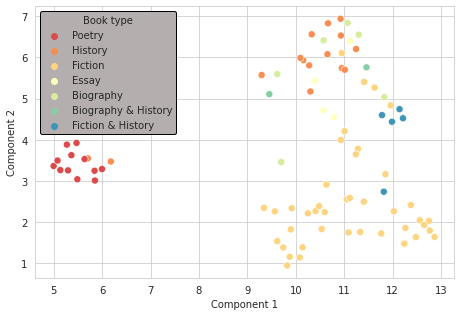

In [47]:
plt = make_plot(candidates, n_neighbors=10, min_dist=.1)
plt.tight_layout()
plt.savefig("fig_2_umap.pdf", dpi=1000)

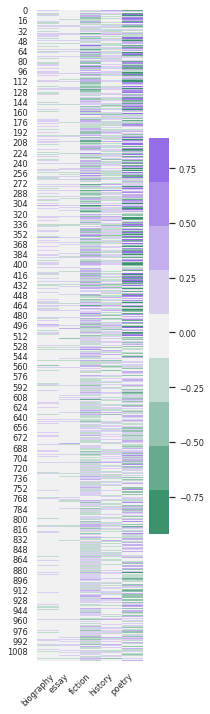

In [48]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
#numpy.cov(np.stack(embedding_dataset.embedding.tolist()), y=None, rowvar=False)
candidates = embedding_dataset[embedding_dataset.simple_subject.apply(len) > 0]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(candidates.simple_subject.tolist())
x = np.stack(candidates.embedding.tolist())

corr = np.zeros((x.shape[-1], y.shape[-1]))
sns.set(font_scale = .75)

for i, x_var in enumerate(x.T):
    for j, y_var in enumerate(y.T):
        corr[i, j] = np.corrcoef(x_var, y_var)[1, 0]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(3, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, square=False, linewidths=0)#, cbar_kws={"shrink": .5})
ax.set_xticks(range(len(mlb.classes_)), mlb.classes_, rotation = 45)
f.tight_layout()
plt.savefig("fig_1_corr.pdf", dpi=1000)

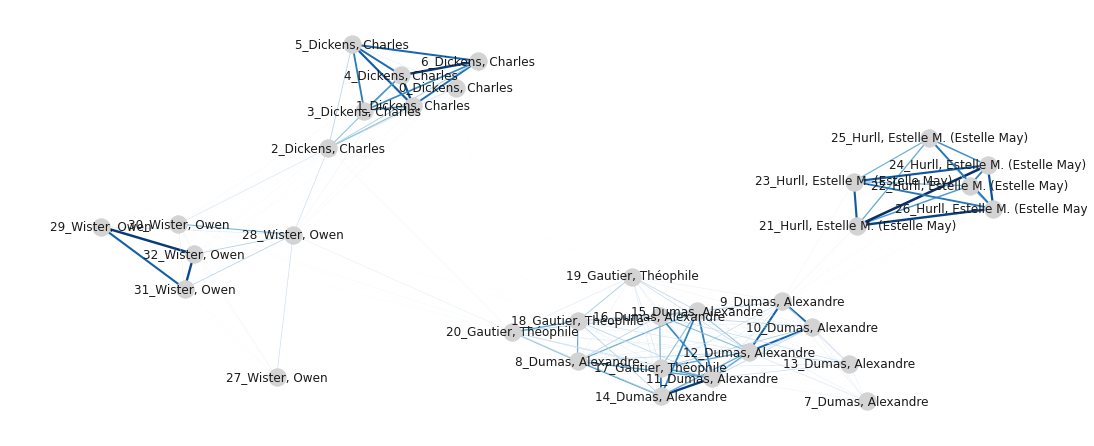

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

candidates = set(embedding_dataset.author.value_counts()[:5].index.tolist())
dup_dataset = embedding_dataset[embedding_dataset.author.isin(candidates)].groupby('author').apply(lambda x: x.iloc[:10])
dup_dataset

#G = nx.Graph(edges = [(1, 2, 1), (2, 3, 2), (3, 4, 1), (4, 5, 2)]
th = .8
cs = cosine_similarity(dup_dataset.embedding.tolist())
cs = (cs - th) / (1 - th)
cs[cs<0] = 0
cs *= np.tri(*cs.shape)
np.fill_diagonal(cs, 0)

col_row = dup_dataset.author.tolist()
G = nx.to_networkx_graph(cs**2)
G = nx.relabel_nodes(G, {k: f'{k}_{v}' for k, v in zip(range(len(col_row)),col_row)})
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

plt.figure(figsize=(15,6))
pos = nx.spring_layout(G, k=0.5, iterations=40)
#pos = nx.spectral_layout(G, scale=1e-5)
nx.draw(G, pos, node_size=300, node_color = 'lightgrey', edge_color=weights,
        width=3*np.array(weights),
        with_labels=True,
        edge_cmap=plt.cm.Blues)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()
plt.savefig("fig_2_graph.pdf", dpi=1000)

In [55]:
for i in weights:
    print(f'{i:.20f}')

0.13192594051361083984
0.18285080790519714355
0.01738692261278629303
0.12896379828453063965
0.13114511966705322266
0.03993807733058929443
0.00040853436803445220
0.00636374251917004585
0.02166132628917694092
0.02263041213154792786
0.02432194910943508148
0.02959064021706581116
0.04349662363529205322
0.38433134555816650391
0.53232467174530029297
0.74435007572174072266
0.70989066362380981445
0.64151936769485473633
0.05744198337197303772
0.05830216780304908752
0.10270505398511886597
0.34978422522544860840
0.26017203927040100098
0.29151749610900878906
0.00905032269656658173
0.02290363609790802002
0.02681954577565193176
0.00007349523366428912
0.08406361192464828491
0.20959150791168212891
0.02743121795356273651
0.15952844917774200439
0.03523445874452590942
0.05627088993787765503
0.51199972629547119141
0.60610610246658325195
0.56421726942062377930
0.65372246503829956055
0.80899077653884887695
0.00551940826699137688
0.09315790981054306030
0.06640395522117614746
0.00186371372547000647
0.670127511

In [ ]:
!sudo apt-get install graphviz -y
!pip install plotly pydot networkx

In [ ]:
#Graph ideas
#-umap projection with
#--genre centroids (fiction, essay, and so on)
#--year of writing
#--

In [35]:
class Baseline(torch.nn.Module):
    def __init__(self, transformer,
                ):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, attention_mask=None):        
        embeds = self.transformer(input_ids, attention_mask).last_hidden_state
        
        if attention_mask is not None:
            embeds = torch.sum(embeds * attention_mask.unsqueeze(-1), axis=1) / attention_mask.sum(1).unsqueeze(-1)
        else:
            embeds = embeds.mean(1)
        return F.normalize(embeds)


class CausalBaseline(torch.nn.Module):
    def __init__(self, transformer,
                ):
        super().__init__()
        self.transformer = transformer
        
    def forward(self, input_ids, attention_mask=None):        
        embeds = self.transformer(input_ids, attention_mask=attention_mask).last_hidden_state
        
        if attention_mask is not None:
            reverse_seq_lens = (1-attention_mask).sum(-1) + 1 #Assume padding only at the end of the sequence
            x_ids = torch.arange(0, len(embeds)).long().to(embeds.device)
            embeds = embeds[x_ids, -reverse_seq_lens]
        else:
            embeds = embeds[:, -1]
        return F.normalize(embeds)

In [36]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score
from transformers import AutoModel, AutoTokenizer, BertTokenizer

import torch.nn.functional as F
import numpy as np

acc, topk = [], []
results = {}
N = [10, 20, 40, 60, 80, 100] 

DEVICE=1
model_tag = 'nvidia/megatron-bert-cased-345m'
tokenizer = BertTokenizer.from_pretrained(model_tag)
base_transformer = AutoModel.from_pretrained('megatron/megatron-bert')
baseline = Baseline(base_transformer).cuda(DEVICE)

for n in N:
    test_data = build_dataset(test, tokenizer, steps=n*100, batch_size=n, num_workers=2, prefetch_factor=2, max_len=512)
    log_name = f'N={n}'
    for a_ids, a_att, b_ids, b_att in tqdm(iter(test_data)):
        with torch.no_grad():
            a_emb = baseline(a_ids.cuda(DEVICE), a_att.cuda(DEVICE))
            b_emb = baseline(b_ids.cuda(DEVICE), b_att.cuda(DEVICE))

            logits = a_emb @ b_emb.T
            preds_a = F.softmax(logits, dim=-1)
            preds_b = F.softmax(logits.T, dim=-1)

            labels = torch.arange(0, len(logits)).numpy()

            a_topk = top_k_accuracy_score(labels, preds_a.cpu().numpy(), k=5)
            b_topk = top_k_accuracy_score(labels, preds_b.cpu().numpy(), k=5)

            a_acc = accuracy_score(labels, preds_a.argmax(-1).cpu().numpy())
            b_acc = accuracy_score(labels, preds_b.argmax(-1).cpu().numpy())

            acc.append((a_acc+b_acc)/2)
            topk.append((a_topk+b_topk)/2)
            
    results[log_name] = {'Top-1 Accuracy average': np.mean(acc), 'Top-1 Accuracy std': np.std(acc),
                          'Top-5 Accuracy average': np.mean(topk), 'Top-5 Accuracy std': np.std(topk),
                         }
    print(n)
    print(results[log_name])
final_frame = pd.DataFrame(results)
print(final_frame.to_latex())

404 Client Error: Not Found for url: https://huggingface.co/nvidia/megatron-bert-cased-345m/resolve/main/config.json
Some weights of the model checkpoint at megatron/megatron-bert were not used when initializing MegatronBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████

10
{'Top-1 Accuracy average': 0.6875, 'Top-1 Accuracy std': 0.14889173919328097, 'Top-5 Accuracy average': 0.9169999999999999, 'Top-5 Accuracy std': 0.062136945531623904}



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

20
{'Top-1 Accuracy average': 0.657, 'Top-1 Accuracy std': 0.14217418893737357, 'Top-5 Accuracy average': 0.887875, 'Top-5 Accuracy std': 0.07189304121401457}



100%|██████████| 100/100 [04:52<00:00,  2.93s/it]

40
{'Top-1 Accuracy average': 0.6270833333333333, 'Top-1 Accuracy std': 0.1354346141952722, 'Top-5 Accuracy average': 0.8580833333333334, 'Top-5 Accuracy std': 0.0826783005926518}



100%|██████████| 100/100 [07:14<00:00,  4.35s/it]

60
{'Top-1 Accuracy average': 0.5952708333333334, 'Top-1 Accuracy std': 0.1351026342755553, 'Top-5 Accuracy average': 0.8306458333333333, 'Top-5 Accuracy std': 0.09080360513141045}



100%|██████████| 100/100 [09:37<00:00,  5.77s/it]

80
{'Top-1 Accuracy average': 0.5729916666666668, 'Top-1 Accuracy std': 0.13042476519051127, 'Top-5 Accuracy average': 0.8068166666666667, 'Top-5 Accuracy std': 0.09647381121319919}



100%|██████████| 100/100 [12:25<00:00,  7.45s/it]

100
{'Top-1 Accuracy average': 0.5547097222222223, 'Top-1 Accuracy std': 0.12688222337735927, 'Top-5 Accuracy average': 0.7866805555555555, 'Top-5 Accuracy std': 0.09993153520483443}
\begin{tabular}{lrrrrrr}
\toprule
{} &      N=10 &      N=20 &      N=40 &      N=60 &      N=80 &     N=100 \\
\midrule
Top-1 Accuracy average &  0.687500 &  0.657000 &  0.627083 &  0.595271 &  0.572992 &  0.554710 \\
Top-1 Accuracy std     &  0.148892 &  0.142174 &  0.135435 &  0.135103 &  0.130425 &  0.126882 \\
Top-5 Accuracy average &  0.917000 &  0.887875 &  0.858083 &  0.830646 &  0.806817 &  0.786681 \\
Top-5 Accuracy std     &  0.062137 &  0.071893 &  0.082678 &  0.090804 &  0.096474 &  0.099932 \\
\bottomrule
\end{tabular}



NameError: name 'final_frame' is not defined